# Setup

In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 5.2 MB/s 


In [2]:
from __future__ import print_function

import shap
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [4]:
# Initialize & fit tf-idf vectorizer (see notebook for lab 10)
vect = TfidfVectorizer(min_df=1)
X_train = vect.fit_transform(newsgroups_train.data)
X_test = vect.transform(newsgroups_test.data)

In [28]:
# Train & fit the classifier
model = SGDClassifier(loss = 'log', random_state=5)
model.fit(X_train,newsgroups_train.target)

### Part (B)

Generate a confusion matrix (hint: use [sklearn.metrics.confusion_matrix](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
to evaluate the accuracy of the classifier. The confusion matrix should contain a count of correct Christian, correct Atheist, incorrect Christian, and incorrect Atheist predictions.

In [7]:
# Generate predictions from your SGDClassifier
pred = model.predict(X_test)

In [10]:
# Confusion matrix
matrix = sklearn.metrics.confusion_matrix(newsgroups_test.target,pred,                
                labels=[0,1])
matrix = pd.DataFrame(matrix)
print(matrix)

     0    1
0  268   51
1    4  394


#### Explainer

In [11]:
# Initialize the explainer and apply to test data
linear_explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
s_vals = linear_explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [30]:
# Select 5 documents in the test set for explanation
# doc 1
doc_1 = newsgroups_test.data[380]
print("DOCUMENT 1", '\n', doc_1)
print("END",'\n')

# doc 2
doc_2 = newsgroups_test.data[217]
print("DOCUMENT 2", '\n', doc_2)
print("END",'\n')
# doc 3
doc_3 = newsgroups_test.data[101]
print("DOCUMENT 3", '\n', doc_3)
print("END",'\n')

# doc 4
doc_4 = newsgroups_test.data[99]
print("DOCUMENT 4", '\n', doc_4)
print("END",'\n')

# doc 5
doc_5 = newsgroups_test.data[5]
print("DOCUMENT 5", '\n', doc_5)
print("END",'\n')

DOCUMENT 1 
 From: djohnson@cs.ucsd.edu (Darin Johnson)
Subject: Re: Homosexuality issues in Christianity
Organization: =CSE Dept., U.C. San Diego
Lines: 15

Ok, what's more important to gay Christians?  Sex, or Christianity?
Christianity I would hope.  Would they be willing to forgo sex
completely, in order to avoid being a stumbling block to others,
to avoid the chance that their interpretation might be wrong,
etc?  If not, why not?  Heterosexuals abstain all the time.
(It would be nice if protestant churches had celibate orders
to show the world that sex is not the important thing in life)

To tell the truth, gay churches remind me a lot of Henry the VIII
starting the Church of England in order to get a divorce (or is
this a myth).  Note that I am not denying that gay Christians are
Christian.
-- 
Darin Johnson
djohnson@ucsd.edu  --  Toy cows in Africa

END 

DOCUMENT 2 
 From: dt4%cs@hub.ucsb.edu (David E. Goggin)
Subject: Dreams and out of body incidents
Lines: 38

hey folks,

I'm

In [31]:
# Visually explain 5 documents selected from the test set
lst = [380, 217, 101, 99, 5]
X_test_array = X_test.toarray()
for idx in lst: 
  shap.initjs()
  if newsgroups_test.target[idx]==0:
    print("Atheism Comment:")
  else:
    print("Christian Comment:")
    

  comment_plot = shap.force_plot(
      linear_explainer.expected_value, s_vals[idx,:], X_test_array[idx,:],
      feature_names=vect.get_feature_names()
  )
  display(comment_plot)

Christian Comment:


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Christian Comment:


Christian Comment:


Atheism Comment:


Christian Comment:


### Part (C)


#### Part (i)

In [34]:
# Compute the accuracy of the classifier and the number of misclassified documents
y_test = newsgroups_test.target

acc = sklearn.metrics.accuracy_score(pred, y_test)

misclassified =  np.array(pred != y_test)

misclassified_idx = [i for i, x in enumerate(misclassified) if x]
misclassified_count = np.sum(misclassified)


print(f'The accuracy is {acc}')
print(f'The number of misclassified documents is {misclassified_count}')

The accuracy is 0.9232914923291492
The number of misclassified documents is 55


#### Part (ii)

In [35]:
# function to calculate confidence
# (note: this function assumes your TF-IDF vectorized test data is called X_test)
def get_conf(doc_id):
  '''doc_id: the index of the misclassified documents'''
  conf = []
  for idx in doc_id:
    prob = model.predict_proba(X_test[idx])[0] 
    conf.append(abs(prob[0]-prob[1]))
  return conf

# Calculate conf_i for all misclassified documents 
misclassified_conf = get_conf(misclassified_idx)

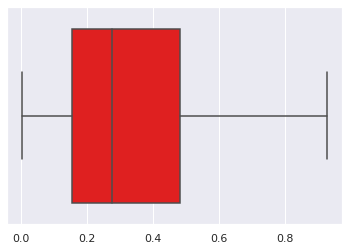

In [42]:
# Plot conf_i

import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.boxplot(x=misclassified_conf, color="red")

#### Part (iii)

Identify all words that contributed to the misclassification of documents. Hint: See the "Prediction decomposition" section of lab 10 notebook.

In [45]:
# Identify words (word_j) that contributed to the misclassification of documents
weight_j = defaultdict(float)
count_j = defaultdict(float)

for idx in misclassified_idx: 
  vals = s_vals[idx,:]
  feats = vect.get_feature_names()

  if pred[idx]==0:
    for f, v in zip(feats, vals):
      if v > 0:
        weight_j[f] += abs(v)
        c = 1 
        count_j[f]+=c
    
  if pred[idx] == 1:
    for f, v in zip(feats, vals):
      if v < 0:
        weight_j[f] += abs(v)
        c = 1 
        count_j[f]+=c

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [46]:
# Compute the number of documents (count_j) these words helped to misclassify
count_j

defaultdict(float,
            {'00': 50.0,
             '0001': 51.0,
             '01': 52.0,
             '02': 51.0,
             '03': 51.0,
             '0358': 51.0,
             '05': 51.0,
             '0510': 51.0,
             '0511': 51.0,
             '06': 51.0,
             '07': 51.0,
             '08': 50.0,
             '09': 51.0,
             '10': 47.0,
             '10101': 51.0,
             '11': 48.0,
             '1122': 51.0,
             '11776': 51.0,
             '1200': 50.0,
             '1271': 51.0,
             '13': 48.0,
             '1379': 51.0,
             '14': 49.0,
             '14368': 51.0,
             '14385': 51.0,
             '14388': 51.0,
             '14556': 51.0,
             '1500': 51.0,
             '152': 51.0,
             '16': 48.0,
             '16937': 51.0,
             '16957': 51.0,
             '17': 50.0,
             '17541': 51.0,
             '17790': 51.0,
             '17799': 51.0,
             '18': 45.0,
    

In [47]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j
weight_j

defaultdict(float,
            {'00': 0.14645639519240292,
             '0001': 0.002262445299243943,
             '01': 0.266195284972364,
             '02': 0.1577536595031822,
             '03': 0.16396277261430656,
             '0358': 0.016619783782442343,
             '05': 0.05885126408305265,
             '0510': 0.006702328239614461,
             '0511': 0.0018218271703971474,
             '06': 0.004788104880874932,
             '07': 0.02347237470504087,
             '08': 0.01234824893320411,
             '09': 0.09031195418886444,
             '10': 0.27978380259783864,
             '10101': 0.00491104874757498,
             '11': 0.1070802036464196,
             '1122': 0.003463404754391985,
             '11776': 0.005566078606722814,
             '1200': 0.002203793839253917,
             '1271': 0.00017817011096565803,
             '13': 0.30425837430709446,
             '1379': 0.0031009977043658698,
             '14': 0.35719476329104366,
             '14368': 0.00112

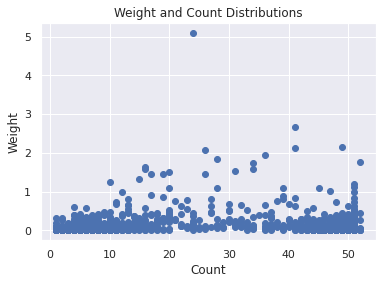

In [48]:
# Plot the distribution of count_j and weight_j
count_d = np.array(list(count_j.items()))
count_a = np.zeros(len(count_d))

for i in range (len(count_d)):
  count_a[i] = count_d[i][1]

weight_d = np.array(list(weight_j.items()))
weight_a = np.zeros(len(weight_d))

for i in range (len(weight_d)):
  weight_a[i] = weight_d[i][1]
plt.title("Weight and Count Distributions")
plt.xlabel("Count")
plt.ylabel("Weight")
plt.scatter(count_a,weight_a)